# <b><center>Movie Review Sentiment Analysis Project</center></b>

In [1]:
# Importing necessary libraries
import gc
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import pickle
import warnings

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 125)
warnings.filterwarnings('ignore')


In [2]:
# Importing the dataset
df = pd.read_csv('IMDB Dataset.csv')


In [3]:
df.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this ...",positive
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives ...,positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and ...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait a...",positive


In [4]:
# Checking the shape of the data
df.shape


(50000, 2)

In [5]:
# Checking the non-null count and datatypes
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


- There are no missing values.

## Data Cleaning

In [6]:
# Checking for duplicate values
df.duplicated().sum()


418

In [7]:
df[df.duplicated(keep=False)].sort_values('review')


,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wrongly the reputation of a film maker with much promise.<br /><br />Its then h...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wrongly the reputation of a film maker with much promise.<br /><br />Its then h...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. Masquerading as a psychological thriller, it's closest relative is the monum...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. Masquerading as a psychological thriller, it's closest relative is the monum...",negative
47527,"""Witchery"" might just be the most incoherent and lamentably scripted horror movie of the 80's but, luckily enough, it has...",negative
...,...,...
47876,this movie sucks. did anyone notice that the entire movie was shot in like 2 rooms. there are NEVER any outside shots and...,negative
44122,"well, the writing was very sloppy, the directing was sloppier, and the editing made it worse (at least i hope it was the ...",negative
23056,"well, the writing was very sloppy, the directing was sloppier, and the editing made it worse (at least i hope it was the ...",negative
10163,"when I first heard about this movie, I noticed it was one of the most controversial films of the 1970s. I noticed the mus...",positive


In [9]:
# Dropping the duplicate rows
df.drop_duplicates(inplace=True)


In [10]:
# Encoding the target column
encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['sentiment'])


In [11]:
df.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this ...",1
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives ...,1
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and ...",1
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all...,0
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait a...",1


### Basic Text Cleaning and Preprocessing

In [12]:
# Lowercasing the text
df['review'] = df['review'].str.lower()


In [13]:
# Removing html tags from the text
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

df['review'] = df['review'].apply(remove_html_tags)


In [14]:
# Removing URLs from the text
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

df['review'] = df['review'].apply(remove_url)


In [15]:
# Removing emails from the text
def remove_emails(text):
    pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
    return pattern.sub(r'', text)

df['review'] = df['review'].apply(remove_emails)


In [16]:
# Removing formatting from the text
df['review'] = df['review'].apply(lambda x: x.replace('! :\x8d','').replace('\x08','').replace('\x9e','').replace('\x8e','').replace('\x97',' ')\
                                 .replace('\t',' ').replace('\xa0',' ').replace('\x10','').replace('\x80','').replace('\x96','').replace('\x84',' ')\
                                 .replace('\x85',' ').replace('\x91',' ').replace('\x95','').replace('\uf0b7','').replace('\xad','').replace('\x9a',''))


In [17]:
# Removing special characters from the text
df['review'] = df['review'].apply(lambda x: x.replace('★','').replace('»',' ').replace('«',' ').replace('▼',' ').replace('…',' ').replace('§','')\
                                  .replace('¡','').replace('¦',"'").replace('®','').replace('¨',' ').replace('¿','').replace('，',' ').replace('、',' ')\
                                  .replace('·',' ').replace('″','').replace('“','').replace('–','').replace('”','').replace('‘',"'").replace('´',"'")\
                                  .replace('’',"'"))


In [18]:
# Tokenization
df['tokens'] = df['review'].apply(nltk.word_tokenize)


In [19]:
# Removing punctuations
punctuations = string.punctuation
def remove_punctuations(tokens):
    new_tokens = []
    for token in tokens:
        if any(char not in punctuations for char in token):
            new_tokens.append(token)

    return new_tokens

df['tokens'] = df['tokens'].apply(remove_punctuations)



In [20]:
# Removing stop words
stop_words = nltk.corpus.stopwords.words('english')
def remove_stopwords(tokens):
    new_tokens = []
    for token in tokens:
        if token not in stop_words:
            new_tokens.append(token)

    return new_tokens

df['tokens'] = df['tokens'].apply(remove_stopwords)



In [21]:
# Removing additional unnecessary tokens
unnecessary_tokens = ["'s", "n't", "'ve", "'m", "'re", "'ll", "'d", "'n", "", "’", "–", "“", ".the", "'the", "i.e", "i.e.", "e.g", ".i", "", 
                      "1.", "2.", "3.", "4.", "5.", "6.", "7.", "8.", "9.", "10.", "a.", "b.", "c.", "d.", "e.", "f.", "g.", "h.", "i.", "j.", "k.", 
                      "l.", "m.", "n.", "o.", "p.", "q.", "r.", "s.", "t.", "u.", "v.", "w.", "x.", "y.", "z.", "mr.", "dr.", "ms.", "jr.", "mrs.", 
                      "1.a.", "it.i", ".it", ".if", "l.a.", ".this", ".in", "-the", "it´s", "lt.", ".as", "co.", "'you", "w/", "-and", ".and", 
                      "it.the", "'em", "st.", ".there", "'it"]


df['tokens'] = df['tokens'].apply(lambda x: [token for token in x if token not in unnecessary_tokens])



In [22]:
# Creating a new column for number of characters
df['num_characters'] = df['review'].apply(len)


In [23]:
# Importing positive and negative word dictionaries
with open('positive_words.txt', 'r') as file:
    positive_words = file.read()
    positive_words = [i.strip() for i in positive_words.split()]

with open('negative_words.txt', 'r') as file:
    negative_words = file.read()
    negative_words = [i.strip() for i in negative_words.split()]


In [24]:
def positive_score(tokens):
    positive_count = 0
    for token in tokens:
        if token in positive_words:
            positive_count += 1
    return positive_count

def negative_score(tokens):
    negative_count = 0
    for token in tokens:
        if token in negative_words:
            negative_count += 1
    return negative_count


In [25]:
df['num_positive_words'] = df['tokens'].apply(positive_score)
df['num_negative_words'] = df['tokens'].apply(negative_score)


In [26]:
df.head()


,review,sentiment,tokens,num_characters,num_positive_words,num_negative_words
0,"one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. they are right, as this ...",1,"[one, reviewers, mentioned, watching, 1, oz, episode, hooked, right, exactly, happened, me.the, first, thing, struck, oz,...",1725,11,18
1,a wonderful little production. the filming technique is very unassuming- very old-time-bbc fashion and gives a comforting...,1,"[wonderful, little, production, filming, technique, unassuming-, old-time-bbc, fashion, gives, comforting, sometimes, dis...",962,11,1
2,"i thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and ...",1,"[thought, wonderful, way, spend, time, hot, summer, weekend, sitting, air, conditioned, theater, watching, light-hearted,...",902,12,6
3,basically there's a family where a little boy (jake) thinks there's a zombie in his closet & his parents are fighting all...,0,"[basically, family, little, boy, jake, thinks, zombie, closet, parents, fighting, time.this, movie, slower, soap, opera, ...",712,2,6
4,"petter mattei's ""love in the time of money"" is a visually stunning film to watch. mr. mattei offers us a vivid portrait a...",1,"[petter, mattei, love, time, money, visually, stunning, film, watch, mattei, offers, us, vivid, portrait, human, relation...",1269,15,2


## Exploratory Data Analysis

In [23]:
df['sentiment'].value_counts()

sentiment
1    24884
0    24698
Name: count, dtype: int64

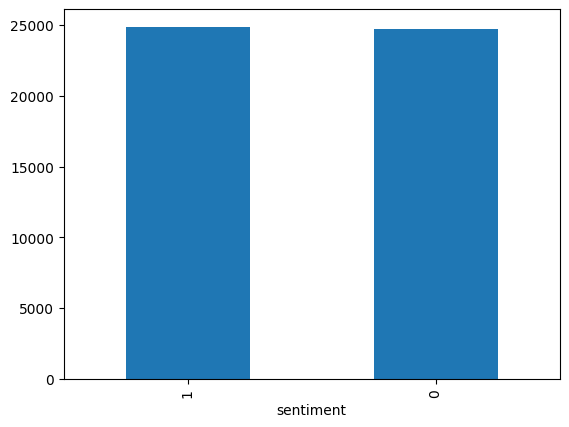

In [24]:
# Checking the distribution of sentiment column
df['sentiment'].value_counts().plot(kind='bar')
plt.show()


- Data is balanced.

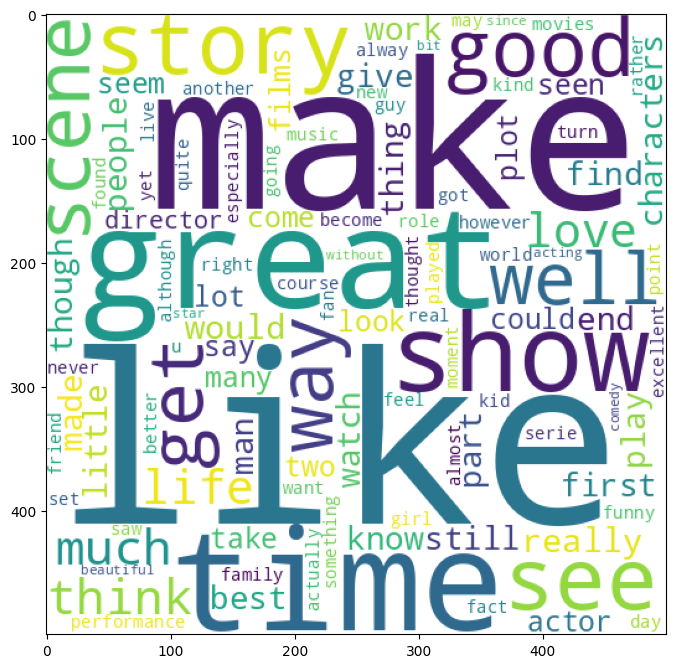

In [26]:
# Plotting the wordcloud of the most common words in positive reviews
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white', stopwords=['even', 'movie', 'film', 'one', 'character', 'also'])
positive_wc = wc.generate(df[df['sentiment']==1]['tokens'].apply(lambda x: ' '.join(x)).str.cat(sep=' '))
plt.figure(figsize=(8,10))
plt.imshow(positive_wc)
plt.show()


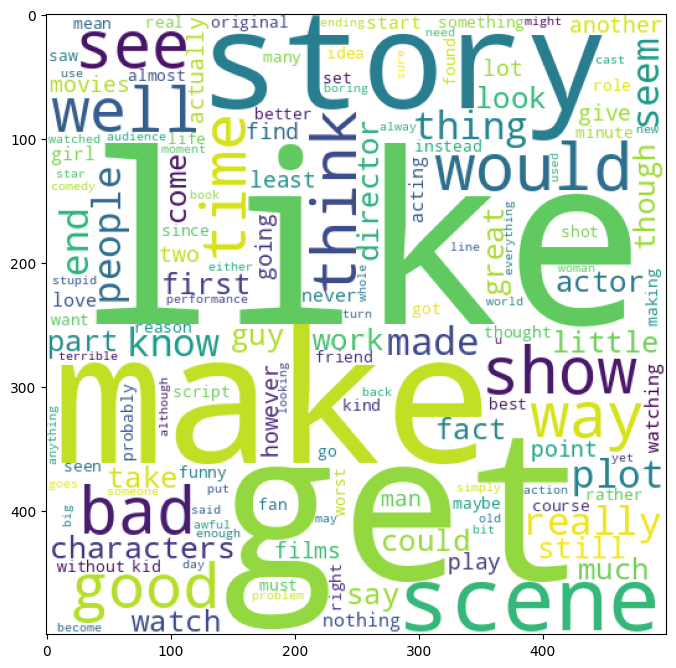

In [27]:
# Plotting the wordcloud of the most common words in negative reviews
negative_wc = wc.generate(df[df['sentiment']==0]['tokens'].apply(lambda x: ' '.join(x)).str.cat(sep=' '))
plt.figure(figsize=(8,10))
plt.imshow(negative_wc)
plt.show()


In [28]:
positive_corpus = []
for tokens in df[df['sentiment']==1]['tokens']:
    for token in tokens:
        positive_corpus.append(token)

negative_corpus = []
for tokens in df[df['sentiment']==0]['tokens']:
    for token in tokens:
        negative_corpus.append(token)



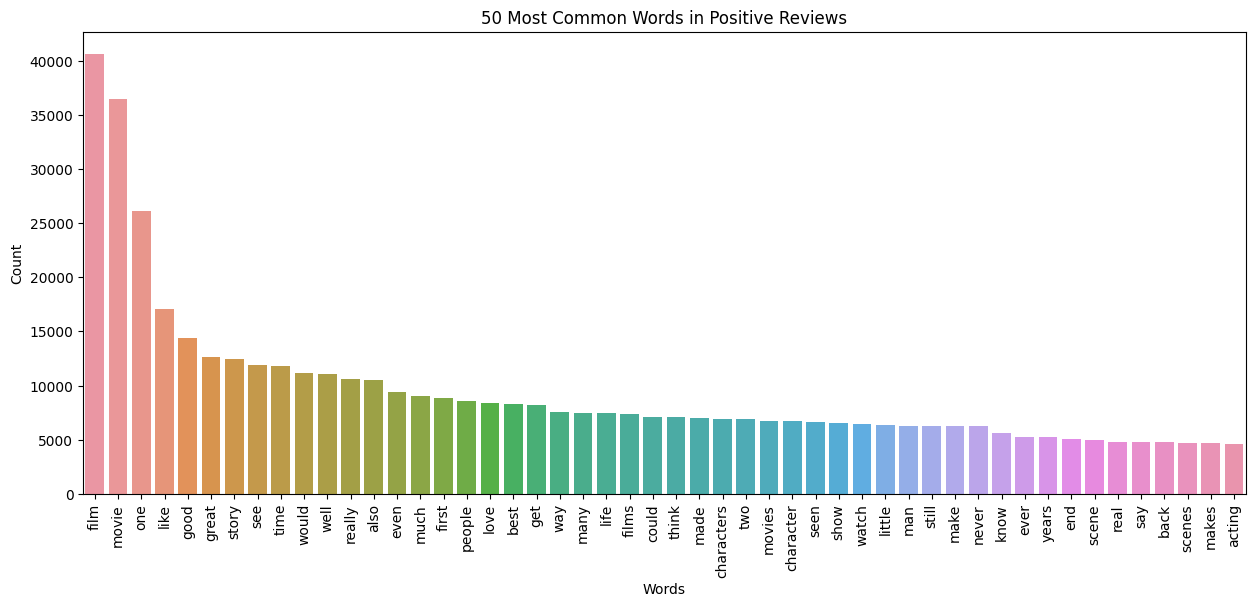

In [29]:
# Plotting the most common 50 words in positive reviews
plt.figure(figsize=(15,6))
sns.barplot(pd.DataFrame(Counter(positive_corpus).most_common(50)), x=0, y=1)
plt.title('50 Most Common Words in Positive Reviews')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()



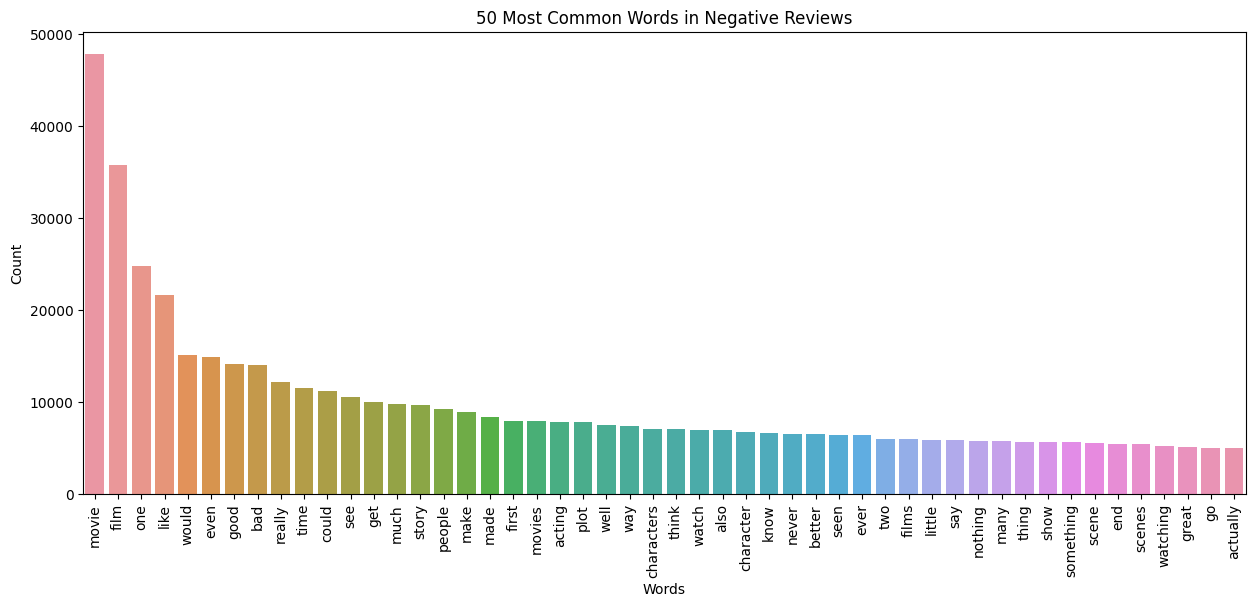

In [30]:
# Plotting the most common 50 words in negative reviews
plt.figure(figsize=(15,6))
sns.barplot(pd.DataFrame(Counter(negative_corpus).most_common(50)), x=0, y=1)
plt.title('50 Most Common Words in Negative Reviews')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()



In [27]:
df.describe()


,sentiment,num_characters,num_positive_words,num_negative_words
count,49582.000000,49582.000000,49582.000000,49582.000000
mean,0.501876,1286.068351,9.725909,9.191360
std,0.500002,972.011998,7.621937,8.271563
min,0.000000,32.000000,0.000000,0.000000
25%,0.000000,689.000000,5.000000,4.000000
50%,1.000000,954.000000,8.000000,7.000000
75%,1.000000,1560.000000,12.000000,12.000000
max,1.000000,13584.000000,92.000000,122.000000


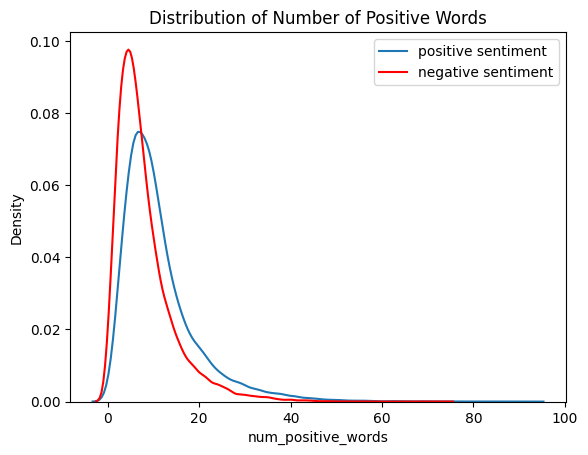

In [40]:
sns.distplot(df[df['sentiment']==1]['num_positive_words'], hist=False, label='positive sentiment')
sns.distplot(df[df['sentiment']==0]['num_positive_words'], hist=False, color='red', label='negative sentiment')
plt.title('Distribution of Number of Positive Words')
plt.legend()
plt.show()


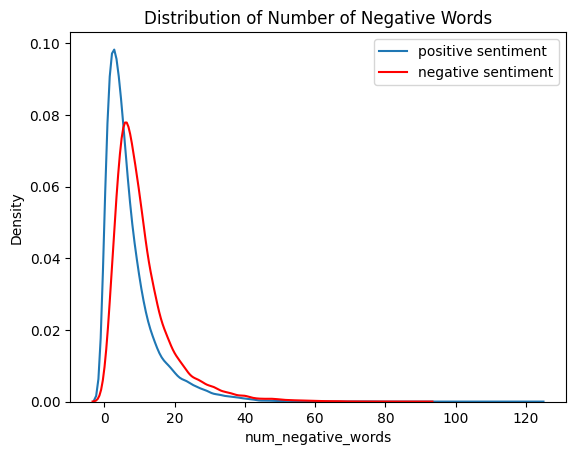

In [41]:
sns.distplot(df[df['sentiment']==1]['num_negative_words'], hist=False, label='positive sentiment')
sns.distplot(df[df['sentiment']==0]['num_negative_words'], hist=False, color='red', label='negative sentiment')
plt.title('Distribution of Number of Negative Words')
plt.legend()
plt.show()


- Positive words are less in negative reviews and negative words are less in positive reviews.

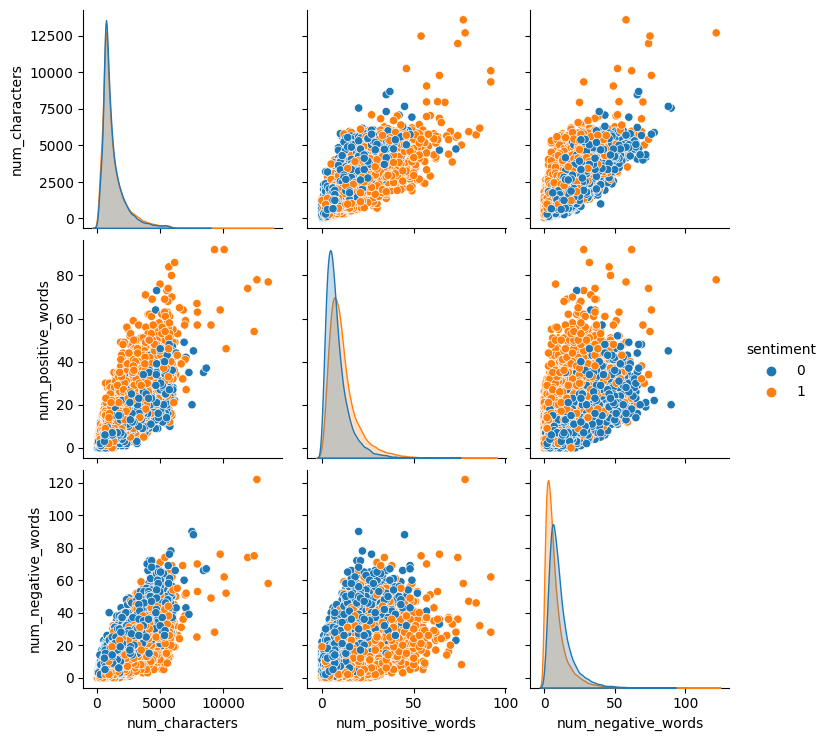

In [ ]:
# Checking the relation between all numerical columns
sns.pairplot(df, hue='sentiment')
plt.show()


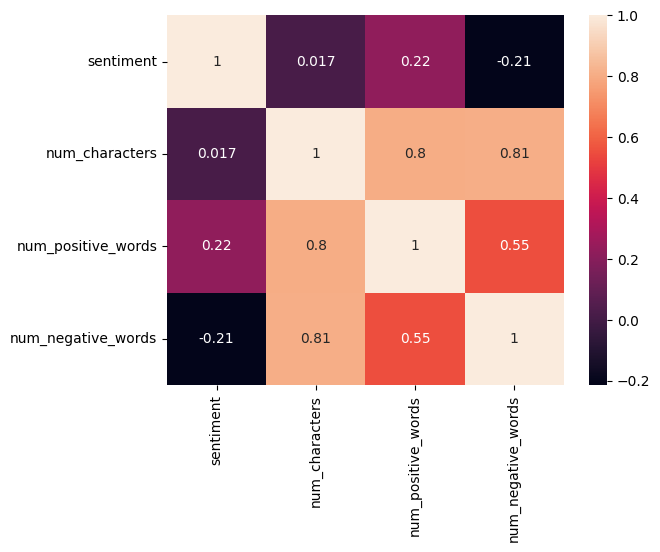

In [37]:
# Checking the correlation between the numerical columns
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()


## Text Preprocessing and Vecorization

In [22]:
# Stemming
ps = nltk.stem.porter.PorterStemmer()
def stem_tokens(tokens):
    new_tokens = []
    for token in tokens:
        new_tokens.append(ps.stem(token))

    return ' '.join(new_tokens)

df['tokens'] = df['tokens'].apply(stem_tokens)



### 1. Bag of Words


In [65]:
cv = CountVectorizer(ngram_range=(1,2), max_features=25000)
X = cv.fit_transform(df['tokens']).toarray()


In [66]:
X.shape


(49582, 25000)

In [67]:
y = df['sentiment']


In [68]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [69]:
# Let's delecte some variables to free up space
del X, cv

In [70]:
gc.collect()

0

# Modeling and Experimentation

In [71]:
bnb1 = BernoulliNB()
bnb1.fit(X_train, y_train)



BernoulliNB()

In [78]:
y_pred = bnb1.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.8642734697993345


In [79]:
print(f1_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)


0.8669960474308301


array([[4184,  725],
       [ 621, 4387]])

In [75]:
mnb1 = MultinomialNB()
mnb1.fit(X_train, y_train)



MultinomialNB()

In [76]:
y_pred = mnb1.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.8614500352929313


In [77]:
print(f1_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)


0.8636904761904761


array([[4190,  719],
       [ 655, 4353]])

In [69]:
del X_train,X_test,y_train,y_test
gc.collect()

0

Let's try tf-idf vectorizer to see if the performance improves.

### TF-IDF Vectorizer

In [70]:
tfidf = TfidfVectorizer(max_features=25000, ngram_range=(1,2))
X = tfidf.fit_transform(df['tokens']).toarray()

In [79]:
X.shape


(49582, 25003)

In [81]:
y = df['sentiment']

In [82]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=5)


In [83]:
del X
gc.collect()

962

In [65]:
bnb = BernoulliNB(alpha=0.1)
bnb.fit(X_train, y_train)



BernoulliNB(alpha=0.1)

In [66]:
y_pred = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.8726429363718866


In [67]:
y_pred_train = bnb.predict(X_train)
accuracy_score(y_train, y_pred_train)


0.889877725954872

In [68]:
print(f1_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)


0.8746650788925275


array([[4247,  688],
       [ 575, 4407]])

In [83]:
mnb = MultinomialNB(alpha=0.1)
mnb.fit(X_train, y_train)



MultinomialNB(alpha=0.1)

In [84]:
y_pred = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.8762730664515479


In [86]:
y_pred_train = mnb.predict(X_train)
accuracy_score(y_train, y_pred_train)


0.9017017521744611

In [85]:
print(f1_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)


0.8783823966696402


array([[4259,  676],
       [ 551, 4431]])

### Other Models

In [84]:
%%time
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

CPU times: user 12.6 s, sys: 5.81 s, total: 18.4 s
Wall time: 8.53 s


0.8928103257033377

In [85]:
y_pred_train = lr.predict(X_train)
accuracy_score(y_train, y_pred_train)


0.9308206227152401

In [86]:
print(f1_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)


0.8944913151364764


array([[4348,  587],
       [ 476, 4506]])

In [ ]:
0.8938186951699103, 0.9334425816210765, 0.8958353942031851, 599, 454

In [118]:
%%time
rf = RandomForestClassifier(max_depth=11, max_samples=0.5, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

CPU times: user 1min 29s, sys: 1.22 s, total: 1min 30s
Wall time: 25.8 s


0.8360391247353031

In [119]:
y_pred_train = rf.predict(X_train)
accuracy_score(y_train, y_pred_train)


0.8614143451405522

In [120]:
print(f1_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)


0.8454078722190531


array([[3845, 1090],
       [ 536, 4446]])

In [59]:
%%time
xgbr = XGBClassifier(n_estimators=50, subsample=0.6, colsample_bytree=0.6, n_jobs=0)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)
accuracy_score(y_test, y_pred)

CPU times: user 12min 17s, sys: 9.49 s, total: 12min 27s
Wall time: 6min 35s


0.8430977110013109

In [60]:
y_pred_train = xgbr.predict(X_train)
accuracy_score(y_train, y_pred_train)


0.879566368334804

In [61]:
print(f1_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)


0.8471212418942817


array([[4050,  885],
       [ 671, 4311]])

In [68]:
%%time
lgbm = LGBMClassifier(n_jobs=-1, verbose=-100)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
accuracy_score(y_test, y_pred)

CPU times: user 6min 12s, sys: 762 ms, total: 6min 13s
Wall time: 1min 43s


0.860542502773016

In [69]:
y_pred_train = lgbm.predict(X_train)
accuracy_score(y_train, y_pred_train)


0.8992310601285768

In [70]:
print(f1_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)


0.8627022734041498


array([[4189,  746],
       [ 637, 4345]])

### Voting CLassifier

In [71]:
vc = VotingClassifier(estimators=[('mnb', MultinomialNB(alpha=0.1)), 
                                  ('lr', LogisticRegression(solver='liblinear')), 
                                  ('rf', RandomForestClassifier(max_depth=11, max_samples=0.5, n_jobs=-1)), 
                                  ('xgbr', XGBClassifier(n_estimators=50, subsample=0.6, colsample_bytree=0.6, n_jobs=0)), 
                                  ('lgbm', LGBMClassifier(n_jobs=-1, verbose=-100))], 
                      voting='soft', n_jobs=-1)

In [72]:
%%time
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
accuracy_score(y_test, y_pred)


CPU times: user 13.1 s, sys: 11.3 s, total: 24.4 s
Wall time: 14min 5s


0.8858525763839871

In [73]:
y_pred_train = vc.predict(X_train)
accuracy_score(y_train, y_pred_train)


0.923030379427707

In [74]:
print(f1_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)


0.8884729064039409


array([[4276,  659],
       [ 473, 4509]])

### Trying Scaling

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
%%time
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

CPU times: user 14min 33s, sys: 34.1 s, total: 15min 8s
Wall time: 14min 29s


0.8607441766663305

In [29]:
y_pred_train = lr.predict(X_train)
accuracy_score(y_train, y_pred_train)


1.0

In [30]:
print(f1_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)


0.8618861886188618


array([[4227,  708],
       [ 673, 4309]])

## Final Model

We observed that the logistic regression model is performing the best in this case. So we will go ahead with this model.

In [32]:
def preprocess_text(text):
    '''This function preprocesses the text and returns the preprocessed text'''

    # Lowercasing the text
    new_text = text.lower()
    
    # Removing HTML tags
    pattern = re.compile('<.*?>')
    new_text = pattern.sub(r'', new_text)
    
    # Removing URLs from the text
    pattern = re.compile(r'https?://\S+|www\.\S+')
    new_text = pattern.sub(r'', new_text)

    # Removing emails from the text
    pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
    new_text = pattern.sub(r'', new_text)
    
    # Removing formatting from the text
    new_text = new_text.replace('! :\x8d','').replace('\x08','').replace('\x9e','').replace('\x8e','').replace('\x97',' ')\
                                 .replace('\t',' ').replace('\xa0',' ').replace('\x10','').replace('\x80','').replace('\x96','').replace('\x84',' ')\
                                 .replace('\x85',' ').replace('\x91',' ').replace('\x95','').replace('\uf0b7','').replace('\xad','').replace('\x9a','')
    
    # Removing special characters from the text
    new_text = new_text.replace('★','').replace('»',' ').replace('«',' ').replace('▼',' ').replace('…',' ').replace('§','')\
                                 .replace('¡','').replace('¦',"'").replace('®','').replace('¨',' ').replace('¿','').replace('，',' ').replace('、',' ')\
                                 .replace('·',' ').replace('″','').replace('“','').replace('–','').replace('”','').replace('‘',"'").replace('´',"'")\
                                 .replace('’',"'")
    
    # Tokenization
    tokens = nltk.word_tokenize(new_text)
    
    # Removing punctuations
    punctuations = string.punctuation
    new_tokens = []
    for token in tokens:
        if any(char not in punctuations for char in token):
            new_tokens.append(token)
    tokens = new_tokens[:]

    # Removing stop words
    stop_words = nltk.corpus.stopwords.words('english')
    new_tokens = []
    for token in tokens:
        if token not in stop_words:
            new_tokens.append(token)
    tokens = new_tokens[:]

    # Removing additional unnecessary tokens
    unnecessary_tokens = ["'s", "n't", "'ve", "'m", "'re", "'ll", "'d", "'n", "", "’", "–", "“", ".the", "'the", "i.e", "i.e.", "e.g", ".i", "", 
                          "1.", "2.", "3.", "4.", "5.", "6.", "7.", "8.", "9.", "10.", "a.", "b.", "c.", "d.", "e.", "f.", "g.", "h.", "i.", "j.", "k.", 
                          "l.", "m.", "n.", "o.", "p.", "q.", "r.", "s.", "t.", "u.", "v.", "w.", "x.", "y.", "z.", "mr.", "dr.", "ms.", "jr.", "mrs.", 
                          "1.a.", "it.i", ".it", ".if", "l.a.", ".this", ".in", "-the", "it´s", "lt.", ".as", "co.", "'you", "w/", "-and", ".and", 
                          "it.the", "'em", "st.", ".there", "'it"]
    tokens = [token for token in tokens if token not in unnecessary_tokens]

    # Stemming
    ps = nltk.stem.porter.PorterStemmer()
    new_tokens = []
    for token in tokens:
        new_tokens.append(ps.stem(token))
    return ' '.join(new_tokens)



In [58]:
del X,tfidf
gc.collect()

27

In [59]:
tfidf = TfidfVectorizer(max_features=25000, ngram_range=(1,2))
X = tfidf.fit_transform(df['tokens']).toarray()


In [60]:
X.shape

(49582, 25000)

In [61]:
y = df['sentiment']

In [62]:
%%time
lr = LogisticRegression(solver='liblinear')
lr.fit(X, y)


CPU times: user 13.3 s, sys: 5.62 s, total: 18.9 s
Wall time: 9.98 s


LogisticRegression(solver='liblinear')

In [63]:
from sklearn.model_selection import cross_val_score
cross_val_score(estimator=lr, X=X, y=y, scoring='accuracy', cv=4)

array([0.89778961, 0.8922233 , 0.8965712 , 0.89447358])

In [64]:
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(lr, open('model.pkl', 'wb'))
